# Data Literacy
#### University of Tübingen, Winter Term 2021/22
## Exercise Sheet 1
&copy; 2021 Prof. Dr. Philipp Hennig & Jonathan Wenger

This sheet is **due on Monday, October 25, 2021 at 12noon sharp (i.e. before the start of the lecture).**

---

## Data Manipulation and Visualization

This first coding exercise will introduce you to some basic concepts of working with data. As a use case we will consider statistics of the ongoing COVID-19 pandemic from two different sources. You will download the data, extract and pre-process the subset we are interested in for downstream analysis and generate some basic visualizations. These will also answer some initial questions you might have about the data and generate new questions regarding estimation of the latent number of infections, the spread of the virus and its mortality.

The tasks will primarily serve as an introduction to `pandas`, a Python tool for data manipulation and basic analysis and `matplotlib` a framework for plotting.

<img src="https://blog.dask.org/images/split-apply-combine.png" alt="split-apply-combine" style="width: 600px;"/>

### Initial Setup

For these homework exercises we expect basic familiarity with Python 3. If you are new to Python there are countless tutorials on the internet, e.g. https://realpython.com/python-first-steps/. As a reference for `pandas` functionality consult the [documentation](https://pandas.pydata.org/docs/).

**Task:** Install the packages `matplotlib`, `numpy` and `pandas` and make sure the cell below executes without errors.

In [13]:
# Make inline plots vector graphics
%matplotlib inline
from IPython.display import set_matplotlib_formats

set_matplotlib_formats("pdf", "svg")

# Plotting setup
import matplotlib.pyplot as plt
import datetime

# Package imports
import numpy as np
import pandas as pd
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

### German COVID-19 Data

We begin by downloading the COVID-19 data for Germany from the [Robert Koch Institute](https://www.rki.de/).

**Task:** Download the CSV data from the given URL and inspect a few rows from it.

In [ ]:
# Link to current data of the RKI
url = "http://www.arcgis.com/sharing/rest/content/items/f10774f1c63e40168479a1feb6c7ca74/data"

# Read CSV data from URL
data_rki = pd.read_csv(url)

# Inspect first few rows of the data
data_rki.head()

**Task:** Based on the shortened description of the data below, compute the cumulative number of cases both in Germany and in Tübingen as of today. Check the RKI dashboard to verify your result.

> #### Data Description of the RKI Covid-19-Dashboard (https://corona.rki.de)
>
> The data has the following features:
> - ...
> - Landkreis: Name of the county
> - ...
> - AnzahlFall: Number of cases in the respective population group.
> - ...
> - NeuerFall:
>    - 0: Case is contained in the data of today and the previous day
>    - 1: Case is only contained in today's data
>    - -1: Case is only contained in the previous day's data

Source (in German): https://www.arcgis.com/home/item.html?id=f10774f1c63e40168479a1feb6c7ca74

In [3]:
# Compute the cumulative number of cases
cases_germany = data_rki[data_rki.NeuerFall > -1].AnzahlFall.sum()
print(f"Total confirmed cases of COVID-19 in Germany: \t{cases_germany:,}")

# Compute the cumulative number of cases in Tübingen
cases_tuebingen = (
    data_rki[data_rki.NeuerFall > -1]
    .groupby(["Landkreis"])
    .get_group("LK Tübingen")
    .AnzahlFall.sum()
)
print(f"Total confirmed cases of COVID-19 in Tübingen: \t{cases_tuebingen:,}")

Total confirmed cases of COVID-19 in Germany: 	4,354,158
Total confirmed cases of COVID-19 in Tübingen: 	11,122


### Incidence Trend

As we recently entered the second lockdown, the main concern over the coming days is whether, and how much the incidence rates are dropping again. 

**Task:** Create three plots of the difference between the number of new cases on any given day and the day directly preceding it normalized by the population size for Germany, Baden-Württemberg and Tübingen. Can you make out a trend already?

In [4]:
# Population sizes
population_sizes = {"Germany": 83783942,
                   "Baden-Württemberg": 11023424,
                   "Tübingen": 228678}

# Germany
data_rki_ger = (
    data_rki[data_rki.NeuerFall > -1]
    .groupby(["Meldedatum"])
    .sum()
    .AnzahlFall.reset_index()
)


def rename_compute_diff(df):
    df = df.rename(columns={"Meldedatum": "date", "AnzahlFall": "new-cases"})
    df["date"] = pd.to_datetime(df["date"])
    df["new-cases-diff"] = df["new-cases"].diff(periods=1)
    return df


data_rki_ger = rename_compute_diff(data_rki_ger)

# Baden Württemberg
data_rki_bw = (
    data_rki[data_rki.NeuerFall > -1]
    .groupby(["Meldedatum", "Bundesland"])
    .sum()
    .AnzahlFall.reset_index()
)
data_rki_bw = data_rki_bw[data_rki_bw.Bundesland == "Baden-Württemberg"]
data_rki_bw = rename_compute_diff(data_rki_bw)

# Tübingen
data_rki_tue = (
    data_rki[data_rki.NeuerFall > -1]
    .groupby(["Meldedatum", "Landkreis"])
    .sum()
    .AnzahlFall.reset_index()
)
data_rki_tue = data_rki_tue[data_rki_tue.Landkreis == "LK Tübingen"]
data_rki_tue = rename_compute_diff(data_rki_tue)

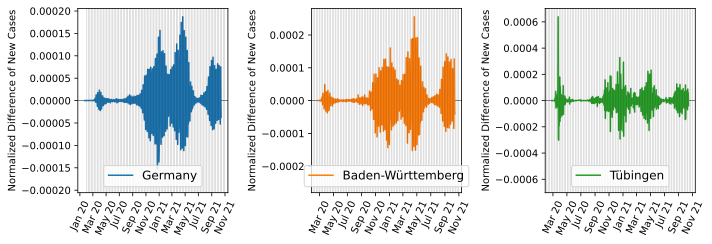

In [5]:
import matplotlib.dates as mdates

# Plot timeseries
fig, axs = plt.subplots(1, 3, figsize=(10, 3.5), sharey=False)

# Initialization
start_date = datetime.datetime.strptime("2020-02-01", "%Y-%m-%d")
end_date = datetime.datetime.strptime("2021-11-01", "%Y-%m-%d")
sundays = pd.date_range(start=start_date, end=end_date, freq="W-SUN").tolist()

# Plot change in new cases
for i, (region, df) in enumerate(
    {
        "Germany": data_rki_ger,
        "Baden-Württemberg": data_rki_bw,
        "Tübingen": data_rki_tue,
    }.items()
):
    axs[i].plot(
        df["date"],
        df["new-cases-diff"] / population_sizes[region],
        label=region,
        color=f"C{i}",
    )
    axs[i].axhline(0, color="k", zorder=-10, linewidth=0.5)

    # Vertical lines for sundays
    for sd in sundays:
        axs[i].axvline(sd, linewidth=0.5, color="k", alpha=0.25)

    # Formatting
    max_abs_cases = (
        np.max(np.abs(df["new-cases-diff"] / population_sizes[region])) * 1.1
    )
    axs[i].set_ylim([-max_abs_cases, max_abs_cases])
    axs[i].set_ylabel("Normalized Difference of New Cases")
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))
    axs[i].xaxis.set_tick_params(rotation=65)
    axs[i].legend(loc="lower center", fontsize=12)

fig.tight_layout()
plt.show()

### Estimating the Basic Reproduction Number $R_0$

Next, we will compute a rough estimate of the _basic reproduction number_ $R_0$ of COVID-19. The reproduction number is used to measure the transmission potential of a disease and constitutes the average number of infections caused by a typical case in a completely susceptible population.

[^1]: https://www.healthknowledge.org.uk/public-health-textbook/research-methods/1a-epidemiology/epidemic-theory

**Task:** Compute and plot a running estimate of the basic reproduction number by computing the ratio between the number of new infections in the last four days and the number of new infections in the four days before that. What can you say about the estimate of the reproduction rate for the current day and over time? If you had to make policy decisions based on this estimate, what would your response be?

*Hint:* To help illustrate your answer to the last two questions, you can use the `datetime` format and `matplotlib` to draw vertical lines on specific dates.

Source $R_0$ estimation: https://www.rki.de/DE/Content/Infekt/EpidBull/Archiv/2020/Ausgaben/17_20.pdf?__blob=publicationFile

In [6]:
# Create dataframe of number of new cases
data_rki_cases = pd.DataFrame(
    data_rki[data_rki.NeuerFall > -1].groupby(["Meldedatum"]).AnzahlFall.sum()
)
data_rki_cases = data_rki_cases.rename(columns={"AnzahlFall": "new-cases"})
data_rki_cases.index.name = "date"

# Compute number of new cases in last four days and in four days prior to that
data_rki_cases["new-cases1-4"] = data_rki_cases.apply(
    lambda x : x.shift().rolling(window=4).sum()
)
data_rki_cases["new-cases5-8"] = data_rki_cases["new-cases1-4"].shift(periods=4)

# Estimate the basic reproduction number R0
data_rki_cases["R0"] = data_rki_cases["new-cases1-4"] / data_rki_cases["new-cases5-8"]

# Show data from the previous week
display(data_rki_cases.tail())

# Reset index and parse dates
data_rki_cases = data_rki_cases.reset_index()
data_rki_cases["date"] = pd.to_datetime(data_rki_cases.date, format="%Y-%m-%d")

new-cases  new-cases1-4  new-cases5-8        R0
date                                                                
2021/10/10 00:00:00       2615       37282.0       26588.0  1.402212
2021/10/11 00:00:00       6126       28848.0       31488.0  0.916159
2021/10/12 00:00:00      12408       24892.0       38935.0  0.639322
2021/10/13 00:00:00      11456       28142.0       42469.0  0.662648
2021/10/14 00:00:00       8330       32605.0       37282.0  0.874551

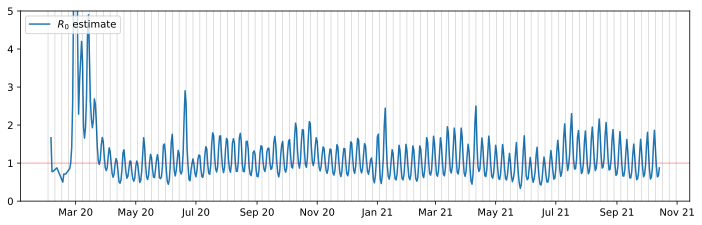

In [7]:
# Plot timeseries
fig, axs = plt.subplots(1, 1, figsize=(12, 3.5))

# Plot reproduction rate
axs.plot(data_rki_cases.date, data_rki_cases.R0, label="$R_0$ estimate")
axs.axhline(1, alpha=0.5, color="r", linewidth=0.75)

# Vertical lines for sundays
start_date = datetime.datetime.strptime("2020-02-01", "%Y-%m-%d")
end_date = datetime.datetime.strptime("2021-11-01", "%Y-%m-%d")
sundays = pd.date_range(start=start_date, end=end_date, freq="W-SUN").tolist()
for sd in sundays:
    axs.axvline(sd, linewidth=0.5, color="k", alpha=0.25)

# Formatting
import matplotlib.dates as mdates

axs.set_ylim([0, 5])
axs.xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))
axs.legend()

plt.show()

### Global COVID-19 Data

Next, we will take a look at the global case numbers for the corona virus from [OurWorldInData.org](https://ourworldindata.org/coronavirus-testing).

**Task:** Download the CSV data from the given URL and parse the `date` column into `datetime` format of the form `2021-11-01`. Why is it important to have a dedicated format for dates instead of just a string representation?

In [8]:
# Link to world-wide COVID data
url = "https://covid.ourworldindata.org/data/owid-covid-data.csv"

# Read CSV data from URL
data_owid = pd.read_csv(url)

# Parse data
data_owid["date"] = pd.to_datetime(data_owid.date, format="%Y-%m-%d")

# Inspect dataframe and datatypes
display(data_owid.head())
data_owid.dtypes[0:5]

iso_code continent     location       date  total_cases  new_cases  \
0      AFG      Asia  Afghanistan 2020-02-24          5.0        5.0   
1      AFG      Asia  Afghanistan 2020-02-25          5.0        0.0   
2      AFG      Asia  Afghanistan 2020-02-26          5.0        0.0   
3      AFG      Asia  Afghanistan 2020-02-27          5.0        0.0   
4      AFG      Asia  Afghanistan 2020-02-28          5.0        0.0   

   new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  ...  \
0                 NaN           NaN         NaN                  NaN  ...   
1                 NaN           NaN         NaN                  NaN  ...   
2                 NaN           NaN         NaN                  NaN  ...   
3                 NaN           NaN         NaN                  NaN  ...   
4                 NaN           NaN         NaN                  NaN  ...   

   female_smokers  male_smokers  handwashing_facilities  \
0             NaN           NaN                  37.746   
1             NaN           NaN                  37.746   
2             NaN           NaN                  37.746   
3             NaN           NaN                  37.746   
4             NaN           NaN                  37.746   

   hospital_beds_per_thousand  life_expectancy  human_development_index  \
0                         0.5            64.83                    0.511   
1                         0.5            64.83                    0.511   
2                         0.5            64.83                    0.511   
3                         0.5            64.83                    0.511   
4                         0.5            64.83                    0.511   

   excess_mortality_cumulative_absolute  excess_mortality_cumulative  \
0                                   NaN                          NaN   
1                                   NaN                          NaN   
2                                   NaN                          NaN   
3                                   NaN                          NaN   
4                                   NaN                          NaN   

   excess_mortality  excess_mortality_cumulative_per_million  
0               NaN                                      NaN  
1               NaN                                      NaN  
2               NaN                                      NaN  
3               NaN                                      NaN  
4               NaN                                      NaN  

[5 rows x 65 columns]

iso_code               object
continent              object
location               object
date           datetime64[ns]
total_cases           float64
dtype: object

In [9]:
data_owid.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       't

**Task:** Subset the world-wide data with the countries of interest and create a new dataframe with seven columns, namely `iso_code`, `date`, `new_cases`, `new_cases_per_million`, `new_cases_smoothed_per_million`, a newly computed `case_fatality_rate` and the `positive_rate`.

*Hint:* The case fatality rate (CFR) is defined as the fraction of deaths and cases.

In [10]:
# Countries of interest (CoIs)
cois = ["DEU", "GBR", "USA", "FRA", "NLD"]

# Subset worldwide data with CoIs
data_owid = data_owid[data_owid["iso_code"].isin(cois)]

# Create CFR column
data_owid["case_fatality_rate"] = data_owid["total_deaths"] / data_owid["total_cases"]

# Remove unnecessary columns
newcols = [
    "iso_code",
    "date",
    "new_cases",
    "new_cases_per_million",
    "new_cases_smoothed_per_million",
    "case_fatality_rate",
    "positive_rate",
]
data_owid.drop(columns=data_owid.columns.difference(newcols), inplace=True)

In [11]:
data_owid.head()

iso_code       date  new_cases  new_cases_per_million  \
39952      FRA 2020-01-24        2.0                  0.030   
39953      FRA 2020-01-25        1.0                  0.015   
39954      FRA 2020-01-26        0.0                  0.000   
39955      FRA 2020-01-27        0.0                  0.000   
39956      FRA 2020-01-28        1.0                  0.015   

       new_cases_smoothed_per_million  positive_rate  case_fatality_rate  
39952                             NaN            NaN                 NaN  
39953                             NaN            NaN                 NaN  
39954                             NaN            NaN                 NaN  
39955                             NaN            NaN                 NaN  
39956                             NaN            NaN                 NaN

### Pandemic Severity across Countries

**Task:** From the world-wide data generate timeseries plots showing new cases per million inhabitants (both raw and smoothed), the computed case fatality rate, and the rate of positive tests. Use log-axes where appropriate and make sure your plots are legible and have properly formatted dates! 
 
How do you explain the falling case fatality rate and the increasing positive rate over time? Which country fares the best in terms of the pandemic, which the worst?

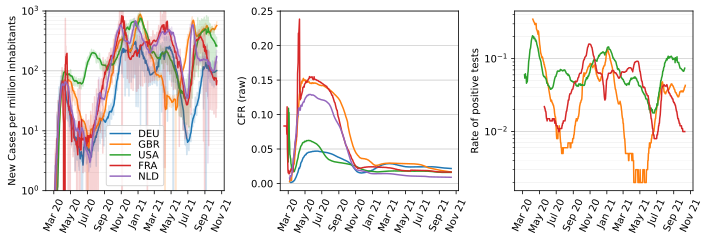

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3.5))

# Plotting colors
colors = dict(zip(cois, ["C0", "C1", "C2", "C3", "C4"]))

# New Cases:
for country in cois:
    df_country = data_owid[data_owid.iso_code == country]

    axs[0].plot(
        df_country.date,
        df_country.new_cases_per_million,
        color=colors[country],
        alpha=0.2,
    )
    axs[0].plot(
        df_country.date,
        df_country.new_cases_smoothed_per_million,
        label=country,
        color=colors[country],
        alpha=1.0,
    )

axs[0].legend(fontsize=10, labelspacing=0.1)
axs[0].set_ylabel("New Cases per million inhabitants")
axs[0].set_yscale("log")
axs[0].set_ylim([1, 1e3])
axs[0].set_xlim(["2020-02-01", "2021-11-10"])
axs[0].grid(axis="y", which="major", linewidth=0.5)
axs[0].grid(axis="y", which="minor", linewidth=0.1)

# Case fatality rate
for country in cois:
    df_country = data_owid[data_owid.iso_code == country]

    axs[1].plot(
        df_country.date,
        df_country.case_fatality_rate,
        label=country,
        color=colors[country],
    )

axs[1].set_xlim(["2020-02-01", "2021-11-10"])
axs[1].grid(axis="y", linewidth=0.5)
axs[1].grid(axis="y", which="minor", linewidth=0.1)
axs[1].set_ylabel("CFR (raw)")

# Rate of positive tests
for country in cois:
    df_country = data_owid[data_owid.iso_code == country]

    axs[2].plot(df_country.date, df_country.positive_rate, color=colors[country])

axs[2].set_xlim(["2020-02-01", "2021-11-10"])
axs[2].grid(axis="y", linewidth=0.5)
axs[2].grid(axis="y", which="minor", linewidth=0.1)
axs[2].set_ylabel("Rate of positive tests")
axs[2].set_yscale("log")


# Date formatting
for i in range(3):
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))
    axs[i].xaxis.set_tick_params(rotation=65)

fig.tight_layout(w_pad=0.1)